In [3]:
## Import Libraries
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

Dataset Overview:


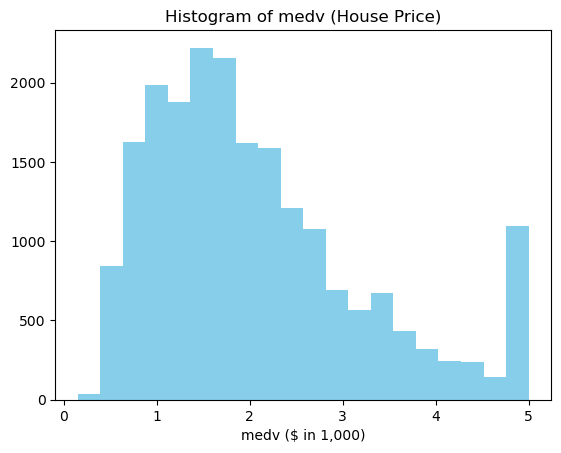

In [5]:
### Objective
# Explore SHAP values for an XGBoost model predicting 'medv' (housing price).

# Load Dataset
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['medv'] = data.target  # medv as target variable

# Show first few rows
print("Dataset Overview:")
df.head()

# Plot the histogram of the target variable (medv)
plt.hist(df['medv'], bins=20, color='skyblue')
plt.title('Histogram of medv (House Price)')
plt.xlabel('medv ($ in 1,000)')
plt.show()

In [12]:
### Split Data into Training and Testing Sets
X = df.drop('medv', axis=1)
y = df['medv']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [14]:
### Build and Train XGBoost Model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, random_state=42)
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Test RMSE: 0.47
Test R^2: 0.83


 95%|=================== | 3917/4128 [00:15<00:00]       

First Observation:
MedInc           1.681200
HouseAge        25.000000
AveRooms         4.192201
AveBedrms        1.022284
Population    1392.000000
AveOccup         3.877437
Latitude        36.060000
Longitude     -119.010000
Name: 20046, dtype: float64


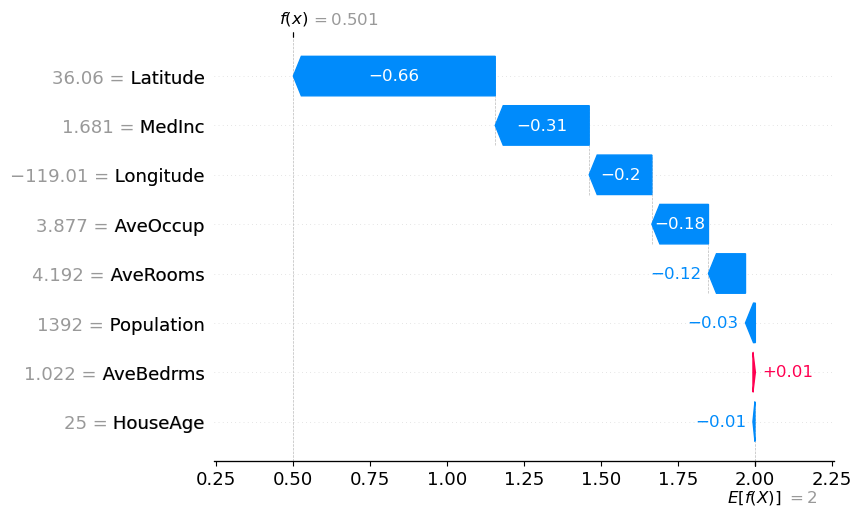

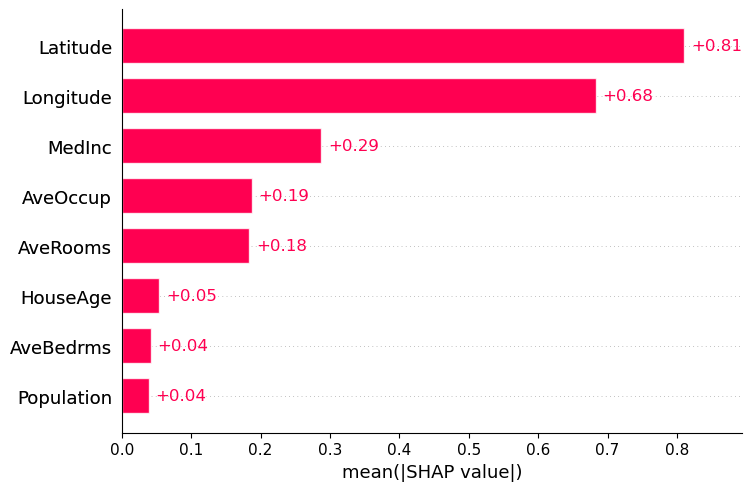

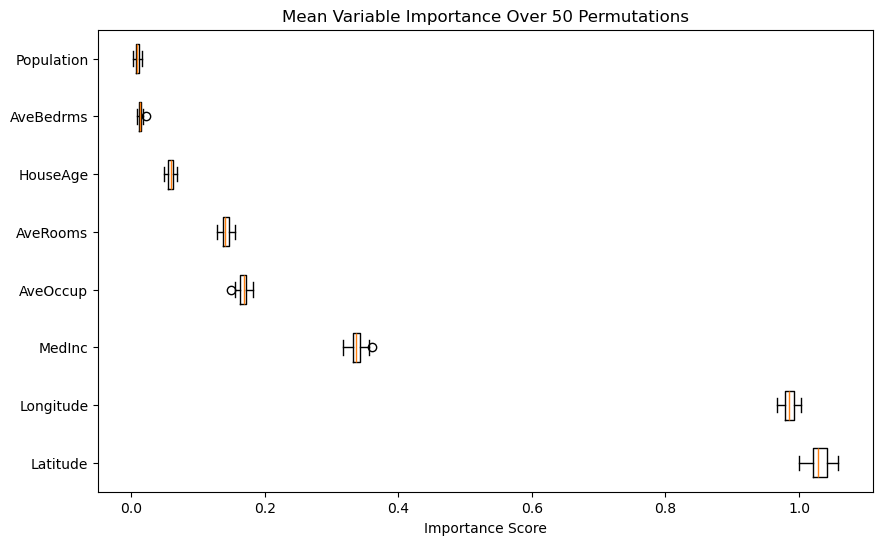

In [15]:
# Predict on test data
y_pred = xgb_model.predict(X_test)

# Calculate RMSE and R^2
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test R^2: {test_r2:.2f}")

### Explain Model Predictions Using SHAP
# Create SHAP Explainer
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)

# Plot SHAP values for one observation (Instance-Level Analysis)
print("First Observation:")
print(X_test.iloc[0])

shap.plots.waterfall(shap_values[0])

# Global Feature Importance Plot (Mean Absolute SHAP Value)
shap.plots.bar(shap_values, max_display=10)

### Global Feature Importance with Permutation
from sklearn.inspection import permutation_importance

result = permutation_importance(xgb_model, X_test, y_test, scoring='neg_root_mean_squared_error', n_repeats=50, random_state=42)

# Sort by importance
sorted_idx = result.importances_mean.argsort()[::-1]
plt.figure(figsize=(10, 6))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
plt.title('Mean Variable Importance Over 50 Permutations')
plt.xlabel('Importance Score')
plt.show()

### Conclusion
# SHAP provides insights into variable importance at both instance and global levels. 
# In this example, the most important features were identified using SHAP and permutation-based feature importance.
